In [2]:
import genjax
import jax
import jax.numpy as jnp
from genjax import ChoiceMapBuilder as CMB
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
from maskcombinator_model import multifirefly_model as model
genjax.pretty()


In [22]:
constraints

Static({
  'n_fireflies': Choice(v=1),
  'steps': Or(
    c1=Or(
      c1=Or(
        c1=Indexed(c=Static({'dynamics': Indexed(c=Static({'x': Choice(v=<jax.Array([12.], dtype=float32)>)}), addr=0)}), addr=0),
        c2=Indexed(c=Static({'dynamics': Indexed(c=Static({'y': Choice(v=<jax.Array([12.], dtype=float32)>)}), addr=0)}), addr=0),
      ),
      c2=Indexed(
        c=Static({'dynamics': Indexed(c=Static({'x': Choice(v=<jax.Array([23.], dtype=float32)>)}), addr=0)}),
        addr=19,
      ),
    ),
    c2=Indexed(
      c=Static({'dynamics': Indexed(c=Static({'y': Choice(v=<jax.Array([25.], dtype=float32)>)}), addr=0)}),
      addr=19,
    ),
  ),
})

In [42]:
importance = jax.jit(model.importance)

In [56]:
key = jax.random.PRNGKey(124512)

# Generate constraints for a firefly that starts at X0 and ends at X1
x0 = 12.
y0 = 12.
y1 = 25.
x1 = 23.
init_vx = .5
init_vy = .5

constraints = CMB["n_fireflies"].set(1)
constraints = constraints | CMB["init", 0, "x"].set(jnp.array(x0 - 0.5))
constraints = constraints | CMB["init", 0, "y"].set(jnp.array(y0 - 0.5))
constraints = constraints | CMB["init", 0, "vx"].set(jnp.array(init_vx))
constraints = constraints | CMB["init", 0, "vy"].set(jnp.array(init_vy))
constraints = constraints | CMB["steps", 0, "dynamics", 0, "x"].set(jnp.array(x0))
constraints = constraints | CMB["steps", 0, "dynamics", 0, "y"].set(jnp.array(y0))
constraints = constraints | CMB["steps", 19, "dynamics", 0, "x"].set(jnp.array(x1))
constraints = constraints | CMB["steps", 19, "dynamics", 0, "y"].set(jnp.array(y1))

subkeys = jax.random.split(key, 1000)
max_fireflies = jnp.arange(1, 2)
time_steps = jnp.arange(20) < 20
model_args = (max_fireflies, time_steps)
tr, weights = jax.vmap(importance, in_axes=(0, None, None))(subkeys, constraints, model_args)

In [57]:
choices = jax.vmap(lambda t: t.get_sample(), in_axes=(0,))(tr)
xs = choices["steps", :, "dynamics", :, "x"].value.squeeze()
ys = choices["steps", :, "dynamics", :, "y"].value.squeeze()

In [58]:
weights_norm = weights / jnp.sum(weights)

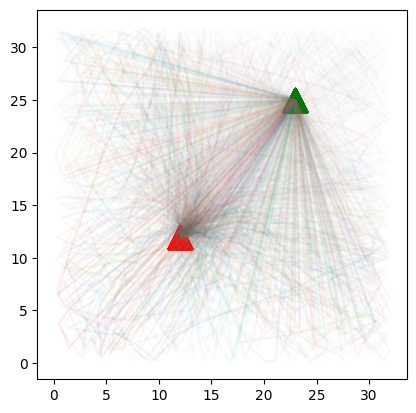

In [62]:
fig, ax = plt.subplots()
for i in range(xs.shape[0]):
    start = (xs[i, 0], ys[i, 0])
    end = (xs[i, -1], ys[i, -1])

    ax.plot(xs[i, :], ys[i, :], alpha=float(weights_norm[i]) * 20)
    ax.scatter(*start, color="red", marker="^", s=300)
    ax.scatter(*end, color="green", marker="^", s=300)

ax.set_aspect('equal')
plt.show()

In [ ]:
@genjax.gen 
def brownian_bridge(step, total_steps, start, stop):
    T = 1.
    t = (step * T) / (total_steps - 1)
    std = jnp.sqrt(t * (T - t) / T)
    position = genjax.normal(start + (t/T) * (stop - start), std) @ "x"
    return position

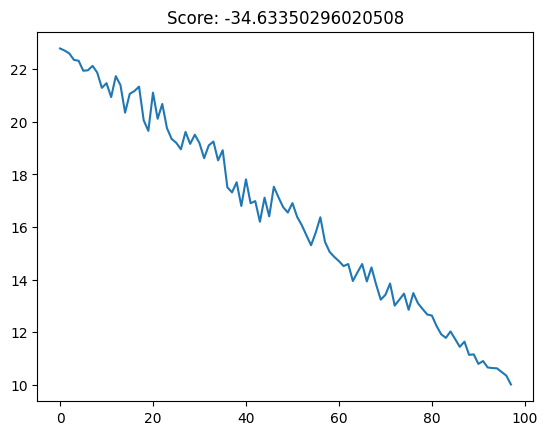

In [ ]:
steps = 100
model_args = (jnp.arange(1, steps - 1), jnp.ones(steps - 2) * steps, jnp.ones(steps - 2) * 23, jnp.ones(steps - 2) * 10)
key = jax.random.PRNGKey(133)
subkeys = jax.random.split(key, steps - 2)
model = jax.jit(jax.vmap(brownian_bridge.simulate, in_axes=(0, 0)))
tr = model(subkeys, model_args)
plt.plot(tr.get_sample()["x"])
plt.title(f"Score: {tr.get_score()}")
plt.show()

In [9]:
scores = jax.vmap(lambda x: x.get_score())(tr)
print(scores)

[ 1.2266672   0.894939    0.09662247  0.70531774 -0.6849936  -0.3889122
  0.4052748   0.23823097  0.32763025 -0.00839192  0.22145963  0.17799586
  0.09471658 -1.1309061   0.10126629 -0.7576248  -1.1417544   0.02068812
 -0.27764976 -0.444105   -1.6690838  -1.1229692  -0.05948291 -0.07873082
 -0.09582355 -0.38472146 -0.15235646 -0.28006592 -0.83769065 -0.32021022
 -1.1346192  -0.17977844 -0.22200729 -0.38985264 -2.268732   -0.5843501
 -0.40854812 -0.28334305 -1.1842499  -0.7252422  -0.2558775  -2.455269
 -0.964927   -0.33198458 -0.2217397  -0.24266006 -0.70938694 -0.22824503
 -0.32307377 -0.5157325  -0.4110439  -0.22494921 -1.2329851  -2.2858024
 -1.1704843  -0.5780734  -0.23843837 -0.40532535 -0.42301932 -0.39390773
 -0.21316141 -2.0328274  -1.0300889  -1.5371466  -0.4302868  -0.37394428
 -0.1646141  -0.15885535 -1.8092899  -0.20158532 -0.12922503 -0.6217379
 -0.16448927 -1.307796   -1.8746035  -0.08104426 -0.3539446  -0.32650366
 -0.29880634 -1.4571606  -1.9245179  -0.87893087 -0.87543